__Visualized Transformer Attention with DINO__

Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import timm
import dino
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cpu")

c:\Users\bjohnson\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load ViT Model

In [3]:
#model = timm.create_model('vit_small_patch16_224_dino',pretrained=True)
model = torch.hub.load('facebookresearch/dino:main','dino_vits16')

Using cache found in C:\Users\bjohnson/.cache\torch\hub\facebookresearch_dino_main


Visualize attention

Load image:

In [4]:
image = Image.open("img2.jpg")
Tx = transforms.Resize((30*20,30*30))(image)
Tx2 = transforms.ToTensor()(Tx).unsqueeze_(0)
Tx3 = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(Tx2)
Tx3.requires_grad = True

print(Tx3.shape)

torch.Size([1, 3, 600, 900])


Feed network

In [6]:
model.eval()
model.to(device)

attentions = model.get_last_selfattention(Tx3)


print(Tx3.shape)
print(attentions.shape)

nh = attentions.shape[1]
attentions = attentions[0, :, 0, 1:].reshape(nh,-1)
print(attentions.shape)

val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)

patch_size = 24

w_featmap = Tx3.shape[-2] // patch_size
h_featmap = Tx3.shape[-1] // patch_size

threshold = 0.6 # We visualize masks obtained by thresholding the self-attention maps to keep xx% of the mass.
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
    
th_attn = th_attn.reshape(nh, w_featmap//2, h_featmap//2).float()

# interpolate
th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().numpy()

attentions = attentions.reshape(nh, w_featmap//2, h_featmap//2)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().numpy()
attentions_mean = np.mean(attentions, axis=0)


torch.Size([1, 3, 600, 900])
torch.Size([1, 6, 2073, 2073])
torch.Size([6, 2072])


RuntimeError: shape '[6, 12, 18]' is invalid for input of size 12432

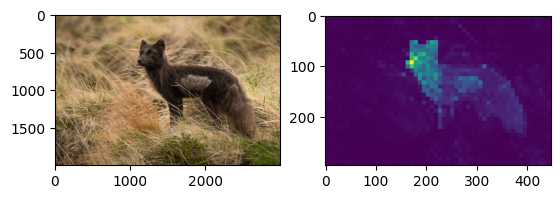

In [13]:
figure = plt.figure()
figure.add_subplot(1,2,1)
plt.imshow(image)
figure.add_subplot(1,2,2)
plt.imshow(attentions_mean)